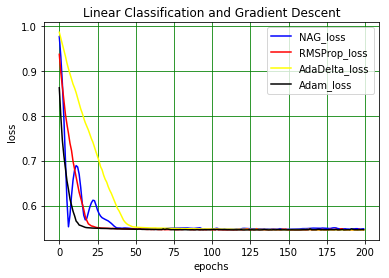

In [6]:
# -*- coding: utf-8 -*-
# Date：12/14 2017
# Title：Linear Classification and Gradient Descent
# Target:Further understand the principles of SVM and practice on larger data
import os
os.chdir('D://dataset')
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_svmlight_file

# 加载训练集
X_train, y_train = load_svmlight_file('a9a_train.txt')
X_train = X_train.toarray()
X_train = np.c_[X_train,np.ones((X_train.shape[0], 1))]# bias
y_train = y_train.reshape(y_train.shape[0], 1)

# 加载测试集
X_test, y_test = load_svmlight_file('a9a_test.txt')
X_test = X_test.toarray()
X_test = np.c_[X_test,np.zeros((X_test.shape[0], 1))]# 最后一维缺失，补上
X_test = np.c_[X_test,np.ones((X_test.shape[0], 1))]# bias
y_test = y_test.reshape(y_test.shape[0], 1)

# 初始化统一参数
epoch = 200
c = 1
BATCH = 100

# 记录验证集的loss随迭代次数的值
lossValidation = []
lossValidationClassification = []

# 计算HingeLoss，返回hingeLoss
def calHingeLoss(Yi, Xi, W):
    result = 1 - (Yi*np.dot(W.T, Xi.T))[0][0]
    if result > 0:
        hingeLoss = result
    else:
        hingeLoss = 0
    return hingeLoss
  
# 计算梯度,返回梯度
def calDirection(X_train, y_train,W):
    temp = np.zeros((X_train.shape[1], 1))
    randIndex = int(np.random.uniform(0,len(X_train) - BATCH))
    for index in range(BATCH):
        Yi = y_train[randIndex+index][0]
        Xi = X_train[randIndex+index].reshape(1, X_train.shape[1])
        hingeLoss = calHingeLoss(Yi, Xi, W)
        if hingeLoss > 0:
            temp = temp + Yi * Xi.T
        else:
            temp = temp+np.zeros((X_train.shape[1], 1))
    direction = W - c * temp/BATCH  
    return direction

# 计算loss，返回Loss
def calLoss(W, X_t, y_t):
    temp = 0
    for index in range(len(X_t)):
        Yi = y_t[index][0]
        Xi = X_t[index].reshape(1, X_t.shape[1])
        temp += calHingeLoss(Yi, Xi, W)
    temp = c * temp  
    Loss = 1/2 * np.dot(W.T, W) + temp/X_t.shape[0]
    return Loss

# 用NAG更新参数
def updateNAG(W, V, direction):   
    learning_rate = 0.01
    GARMA = 0.95
    direction = calDirection(X_train, y_train, W - GARMA*V)
    #direction = direction - GARMA*V
    V = GARMA * V + learning_rate *direction
    W = W - V# 更新参数
    return W, V, direction
    
def NAG_loss():
    # 记录验证集的loss随迭代次数的值
    lossValidation = []
    #lossValidationClassification = []
    direction = np.zeros((X_train.shape[1], 1))
    W = np.zeros((X_train.shape[1], 1))
    V = np.zeros((X_train.shape[1], 1))
       
    for i in range(epoch): 
        W, V, direction = updateNAG(W, V, direction)   
        # 计算测试集的loss
        Ltest = calLoss(W, X_test,y_test)
        lossValidation.append(Ltest[0][0])# 将测试集的loss加入列表

    return lossValidation
    
# 用RMSProp更新参数
def updateRMSProp(W, G):    
    GARMA = 0.95   
    EPSEN = 1e-8
    learning_rate = 0.01
    direction = calDirection(X_train, y_train, W)
    G = GARMA * G + (1 - GARMA)*np.dot(direction.T, direction)
    temp = (learning_rate / np.sqrt(G + EPSEN ))*direction
    W = W - temp# 更新参数
    return W, G

def RMSProp_loss():
    # 记录验证集的loss随迭代次数的值
    lossValidation = []
    #lossValidationClassification = []
    
    W = np.zeros((X_train.shape[1], 1))
    G = np.zeros((X_train.shape[1], 1))
    
    
    for i in range(epoch): 
        W, G = updateRMSProp(W, G)   
        # 计算测试集的loss
        Ltest = calLoss(W, X_test,y_test)
        lossValidation.append(Ltest[0][0])# 将测试集的loss加入列表

    return lossValidation

# 用AdaDelta更新参数
def updateAdaDelta(W, G, deltaT):
    deltaW = np.zeros((X_train.shape[1], 1))
    GARMA = 0.9999
    EPSEN = 1e-8
    
    direction = calDirection(X_train, y_train, W)
    G = GARMA * G + (1 - GARMA)*np.dot(direction.T, direction)
    deltaW = - (np.sqrt(deltaT + EPSEN ) / np.sqrt(G + EPSEN ))*direction
    W = W + deltaW# 更新参数
    deltaT = GARMA * deltaT + (1 - GARMA)*np.dot(deltaW.T, deltaW)
    return W, G, deltaT
def AdaDelta_loss():
    # 记录验证集的loss随迭代次数的值
    lossValidation = []
    #lossValidationClassification = []
    
    W = np.zeros((X_train.shape[1], 1))   
    G = np.zeros((X_train.shape[1], 1))
    deltaT = np.zeros((X_train.shape[1], 1))
    
    for i in range(epoch): 
        W, G, deltaT = updateAdaDelta(W, G, deltaT)   
        # 计算测试集的loss
        Ltest = calLoss(W, X_test,y_test)
        lossValidation.append(Ltest[0][0])# 将测试集的loss加入列表
    return lossValidation

# 用Adam更新参数
def updateAdam(W, G, M, i):
    ALFA = 0
    GARMA = 0.999
    EPSEN = 1e-8
    BELTA = 0.9
    learning_rate = 0.1
      
    direction = calDirection(X_train, y_train, W)
    M = BELTA*M + (1 - BELTA)*direction
    G = GARMA * G + (1 - GARMA)*np.dot(direction.T, direction)
    ALFA = learning_rate*np.sqrt(1 - GARMA**(i+1) )/(1 - BELTA**(i+1))   
    W = W - ALFA*M/np.sqrt(G + EPSEN)
    return W, G, M

def Adam_loss():
    W = np.zeros((X_train.shape[1], 1))   
    G = np.zeros((X_train.shape[1], 1))
    M = np.zeros((X_train.shape[1], 1))
    # 记录验证集的loss随迭代次数的值
    lossValidation = []
    #lossValidationClassification = []
         
    for i in range(epoch): 
        W, G, deltaT = updateAdam(W, G, M, i)   
        # 计算测试集的loss
        Ltest = calLoss(W, X_test,y_test)
        lossValidation.append(Ltest[0][0])# 将测试集的loss加入列表
    return lossValidation    

NAG_loss = NAG_loss()
RMSProp_loss= RMSProp_loss()
AdaDelta_loss = AdaDelta_loss()
Adam_loss = Adam_loss() 

   
    
# loss随迭代次数的变化图   
plt.plot(range(epoch), NAG_loss, label = "NAG_loss", color = 'blue') 
plt.plot(range(epoch), RMSProp_loss, label = "RMSProp_loss", color = 'red') 
plt.plot(range(epoch), AdaDelta_loss, label = "AdaDelta_loss", color = 'yellow') 
plt.plot(range(epoch), Adam_loss, label = "Adam_loss", color = 'black')
plt.xlabel("epochs")  
plt.ylabel('loss')  
plt.title("Linear Classification and Gradient Descent")
plt.grid(True, color = 'g'),
plt.legend()
plt.show()   